In [3]:
import time
!pip install pandas_datareader

import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
#import pandas_datareader as web

import pandas_datareader.data as pdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#plt.style.use('ggplot')

You are using pip version 9.0.3, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [7]:
import os
import numpy as np
import pandas as pd
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def get_json_data(json_url, cache_path):
    '''Download and cache JSON data, return as a dataframe.'''
    try:        
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(json_url))
    except (OSError, IOError) as e:
        print('Downloading {}'.format(json_url))
        df = pd.read_json(json_url)
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(json_url, cache_path))
    return df

In [9]:
base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.strptime('2016-01-01', '%Y-%m-%d') 
end_date = datetime.now() # up until today
period = 86400 # pull daily data (86,400 seconds per day)

def get_crypto_data(poloniex_pair):
    '''Retrieve cryptocurrency data from poloniex'''
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), period)
    data_df = get_json_data(json_url, poloniex_pair)
    data_df = data_df.set_index('date')
    return data_df

In [11]:
crypto = ['BTC', 'ETH', 'LTC','XRP']

crypto_data = {}
for coin in crypto:
    coinpair = 'USDT_{}'.format(coin)
    crypto_price_df = get_crypto_data(coinpair)
    crypto_data[coin] = crypto_price_df

Cached https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1451606400.0&end=1535628019.842803&period=86400 at USDT_BTC
Cached https://poloniex.com/public?command=returnChartData&currencyPair=USDT_ETH&start=1451606400.0&end=1535628019.842803&period=86400 at USDT_ETH
Cached https://poloniex.com/public?command=returnChartData&currencyPair=USDT_LTC&start=1451606400.0&end=1535628019.842803&period=86400 at USDT_LTC
Cached https://poloniex.com/public?command=returnChartData&currencyPair=USDT_XRP&start=1451606400.0&end=1535628019.842803&period=86400 at USDT_XRP


In [12]:
dfp = pd.concat([crypto_data['BTC']['close'],crypto_data['ETH']['close'],crypto_data['LTC']['close'],crypto_data['XRP']['close']], axis=1)

In [18]:
dfp.columns = ['BTC-USD', 'ETH-USD', 'LTC-USD','XRP-USD']
crypto_prices = dfp

In [19]:
crypto_prices.head()

,BTC-USD,ETH-USD,LTC-USD,XRP-USD
date,,,,
2016-01-01,434.990000,0.959136,3.563049,0.005999
2016-01-02,436.949900,0.957000,3.569990,0.006127
2016-01-03,428.140000,0.960499,3.435230,0.006149
2016-01-04,432.000011,0.962224,3.435230,0.006149
2016-01-05,430.376774,0.939382,3.435234,0.006149


In [16]:
def calc_daily_returns(df):
    return (df.pct_change())

In [21]:
crypto_daily_rets = calc_daily_returns(crypto_prices)
print(crypto_daily_rets.head())

             BTC-USD   ETH-USD   LTC-USD   XRP-USD
date                                              
2016-01-01       NaN       NaN       NaN       NaN
2016-01-02  0.004506 -0.002227  0.001948  0.021299
2016-01-03 -0.020162  0.003656 -0.037748  0.003702
2016-01-04  0.009016  0.001796  0.000000  0.000000
2016-01-05 -0.003757 -0.023738  0.000001  0.000000


In [22]:
def calc_mean_daily_returns(daily_returns):
    return (daily_returns.mean())

In [23]:
crypto_mean_daily_rets = calc_mean_daily_returns(crypto_daily_rets)
print(crypto_mean_daily_rets.head())

BTC-USD    0.003744
ETH-USD    0.008165
LTC-USD    0.004908
XRP-USD    0.008153
dtype: float64


In [24]:
def create_covariance_matrix(daily_returns):
    return daily_returns.cov()

In [25]:
crypto_cov_matrix = create_covariance_matrix(crypto_daily_rets)
print(crypto_cov_matrix)

          BTC-USD   ETH-USD   LTC-USD   XRP-USD
BTC-USD  0.001792  0.001095  0.001498  0.000975
ETH-USD  0.001095  0.004785  0.001564  0.001368
LTC-USD  0.001498  0.001564  0.004434  0.002076
XRP-USD  0.000975  0.001368  0.002076  0.010563


In [26]:
def create_results_dataframe(tickers, number_portfolios, mean_daily_returns, cov_matrix):
    results_temp = np.zeros((4 + len(tickers) - 1, number_portfolios))

    for i in range(number_portfolios):
        # select random weights for portfolio holdings
        weights = np.array(np.random.random(4))
        # rebalance weights to sum to 1
        weights /= np.sum(weights)

        # calculate portfolio return and volatility
        portfolio_return = np.sum(mean_daily_returns * weights) * 252
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

        # 3 month T-Bill yield used as risk free rate of return
        risk_free_return = 0.0139

        # store results in results array
        results_temp[0, i] = portfolio_return
        results_temp[1, i] = portfolio_std_dev
        # store Sharpe Ratio (return / volatility) - risk free rate element excluded for simplicity
        results_temp[2, i] = (results_temp[0, i] - risk_free_return) / results_temp[1, i]
        # iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_temp[j + 3, i] = weights[j]

    # convert results array to Pandas DataFrame
    results_df = pd.DataFrame(results_temp.T, columns=['ret', 'stdev', 'sharpe', tickers[0], tickers[1], tickers[2], tickers[3]])
    return results_df

In [27]:
crypto_results = create_results_dataframe(stocks, 10000, crypto_mean_daily_rets, crypto_cov_matrix)
print(crypto_results.head())

        ret     stdev    sharpe   BTC-USD   ETH-USD   LTC-USD   XRP-USD
0  1.197438  0.680919  1.738149  0.557397  0.100069  0.291086  0.051448
1  1.869235  0.908087  2.043124  0.112478  0.735322  0.076489  0.075710
2  1.597483  0.766933  2.064825  0.231189  0.452242  0.246441  0.070128
3  1.697393  0.820083  2.052832  0.155869  0.353100  0.226224  0.264807
4  1.482582  0.827683  1.774450  0.176046  0.136222  0.460675  0.227057


In [28]:
def max_sharpe_ratio(results_df):
    """locate portfolio with highest Sharpe Ratio"""
    return results_df.iloc[results_df['sharpe'].idxmax()]

In [29]:
crypto_max_sharpe_portfolio = max_sharpe_ratio(crypto_results)
print(crypto_max_sharpe_portfolio)

ret        1.661345
stdev      0.763671
sharpe     2.157271
BTC-USD    0.331051
ETH-USD    0.463125
LTC-USD    0.032700
XRP-USD    0.173123
Name: 4279, dtype: float64


In [30]:
def min_volatility(results_df):
    """locate portfolio with lowest volatility"""
    return results_df.iloc[results_df['stdev'].idxmin()]

In [31]:
crypto_min_vol_portfolio = min_volatility(crypto_results)
print(crypto_min_vol_portfolio)

ret        1.186499
stdev      0.642581
sharpe     1.824827
BTC-USD    0.769029
ETH-USD    0.149296
LTC-USD    0.017100
XRP-USD    0.064574
Name: 7089, dtype: float64


In [38]:
def plot_graph(results_df, max_sharpe_port, min_vol_port):
    #f1 = figure()
    #a1 = f1.gca().patch.set_facecolor('0.8')
    #p1 = a1.plot(x,y)
    ax = results_df.plot(kind= 'scatter', x = 'stdev', y='ret', s = 30, c=results_df.sharpe, cmap='RdYlBu',edgecolors='.1', figsize=(20,10))
    #plt.gca().patch.set_facecolor('0.8')
    #plt.grid(True, color='w', linestyle='-', linewidth=1)
    #plt.rcParams['axes.axisbelow'] = True
    
    #ax.gca().patch.set_facecolor('0.8')
    ax.grid(False, color='w', linestyle='-', linewidth=1)
    ax.set_facecolor('4444')
    ax.set_xlabel('Volatility')
    ax.set_ylabel('Returns')
    ax.tick_params(labelsize=15)
    

    #cbar = plt.colorbar()
    #cbar.ax.set_ylabel('Sharpe Ratio')
    #plt.rcParams['figure.figsize'] = (100,100)
    # # plot red star to highlight position of portfolio with highest Sharpe Ratio
    ax.scatter(max_sharpe_port[1], max_sharpe_port[0], marker=(5, 1, 0), color='r', s=1000)
    # # plot green star to highlight position of minimum variance portfolio
    ax.scatter(min_vol_port[1], min_vol_port[0], marker=(5, 1, 0), color='g', s=1000)

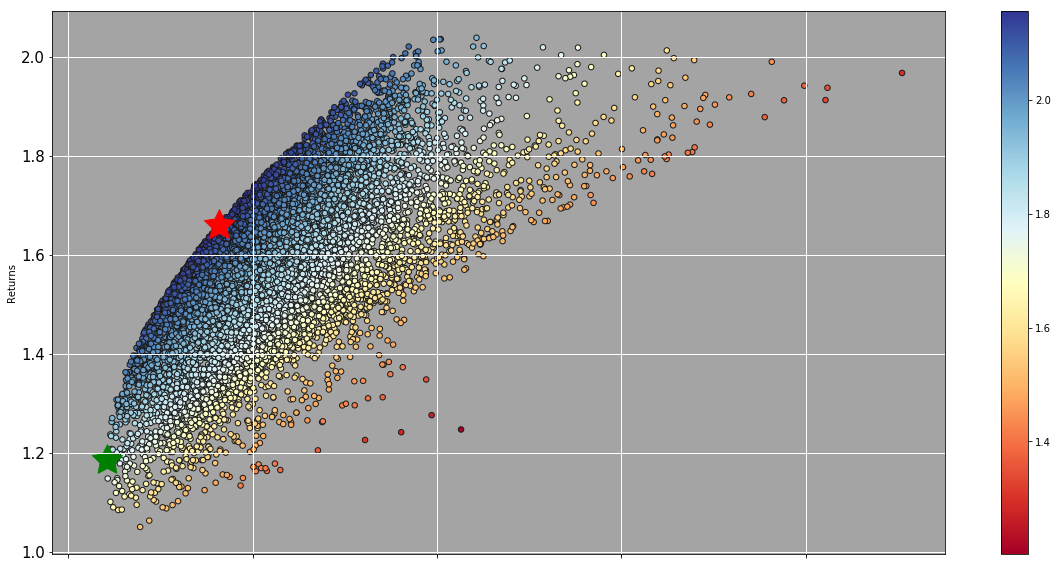

In [39]:
plot_graph(crypto_results, crypto_max_sharpe_portfolio, crypto_min_vol_portfolio)

plt.show()